# Library imports



In [6]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.cuda.amp import GradScaler, autocast

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2
from PIL import Image
import os
from tqdm import tqdm
import glob

# Config

In [92]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CHECKPOINT = "checkpoint.pth.tar"

#ANCHORS는 image 단위에서 [0,1]의 값을 가짐
ANCHORS = [
    [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)],
    [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
    [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)],
]
NUM_CLASSES = 3
BATCH_SIZE=1
LEARNING_RATE=1e-5
EPOCHS=20
IMAGE_SIZE=640
STRIDE=[32, 16, 8]
WEIGHT_DECAY=0
GRID_SIZE=[ (IMAGE_SIZE//s) for s in STRIDE]
CLASS_LABEL=['normal','mite','virus']
IMG_TRAIN_DIR='./kaggle/input/dr-bee/images/train'
LABEL_TRAIN_DIR='./kaggle/input/dr-bee/labels/train'
IMG_TEST_DIR='./kaggle/input/dr-bee/images/test'
LABEL_TEST_DIR='./kaggle/input/dr-bee/labels/test'

# Model Architecture

## Blocks

In [2]:
# Basic Conv Block 정의
class CNNBlock(nn.Module):
    def __init__(self, in_channels:int, out_channels:int, kernel_size:int, stride:int=1,padding:int=0):
        super().__init__()

        self.conv = nn.Sequential(
            # TODO : (Conv, BatchNorm, LeakyReLU) 스펙 보고 구현
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, bias=False,stride=stride,padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1)
        )

    def forward(self, x:torch.tensor):
        return self.conv(x)


# ResidualBlock 정의
class ResidualBlock(nn.Module):
    def __init__(self, in_channels:int, num_repeats:int=1): # residual block은 input channel 수와 output channel 수가 동일하다.
        super().__init__()
        res_layers=[]
        for _ in range(num_repeats):
            res_layers.append(nn.Sequential(
            CNNBlock(in_channels,in_channels//2,kernel_size=1,stride=1,padding=0),
            CNNBlock(in_channels//2,in_channels,kernel_size=3,stride=1,padding=1),
        ))
        self.layers = nn.ModuleList(res_layers)


    def forward(self, x:torch.tensor):
        for layer in self.layers:
            skip_connection = x
            x = layer(x)
            x+=skip_connection
        return x



# DarkNet53 정의
class Darknet53(nn.Module):
    def __init__(self,in_channels:int=3):
        super().__init__()
        # TODO : define darknet53 (위에서 정의한 Conv block과 Res block 활용)
        self.block1 = nn.Sequential(
            CNNBlock(in_channels, 32, kernel_size=3, stride=1, padding=1),
            CNNBlock(32, 64, kernel_size=3, stride=2, padding=1),
            ResidualBlock(64, num_repeats=1),
            CNNBlock(64, 128, kernel_size=3, stride=2, padding=1),
            ResidualBlock(128, num_repeats=2),
            CNNBlock(128, 256, kernel_size=3, stride=2, padding=1),
            ResidualBlock(256, num_repeats=8),
        )
        self.block2 = nn.Sequential(
            CNNBlock(256, 512, kernel_size=3, stride=2, padding=1),
            ResidualBlock(512, num_repeats=8),
        )
        self.block3 = nn.Sequential(
            CNNBlock(512, 1024, kernel_size=3, stride=2, padding=1),
            ResidualBlock(1024, num_repeats=4),
        )

    def forward(self, x:torch.tensor):
        # TODO : Darknet53에서 output으로 나오는 세가지 feature map 생산
        high_feature_map = self.block1(x)
        medium_feature_map = self.block2(high_feature_map)
        low_feature_map = self.block3(medium_feature_map)
        return high_feature_map, medium_feature_map, low_feature_map

class UpSampling(nn.Module):
    def __init__(self, in_channels:int, out_channels:int):
        super().__init__()

        self.upsample = nn.Sequential(
            # TODO : YOLO Network Architecture에서 Upsampling에 사용
            CNNBlock(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
            nn.Upsample(scale_factor=2)
        )
    def forward(self, x:torch.tensor):
        return self.upsample(x)


class YoloBlock(nn.Module):
    def __init__(self,in_channels:int,out_channels:int):
        super().__init__()
        self.route_conv = nn.Sequential(
            # TODO : define route conv & output conv
            CNNBlock(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
            CNNBlock(out_channels, out_channels*2, kernel_size=3, stride=1, padding=1),
            CNNBlock(out_channels*2, out_channels, kernel_size=1, stride=1, padding=0),
            CNNBlock(out_channels, out_channels*2, kernel_size=3, stride=1, padding=1),
            CNNBlock(out_channels*2, out_channels, kernel_size=1, stride=1, padding=0),
        )

    def forward(self, x:torch.tensor):
        route = self.route_conv(x)
        return route        #DetectionLayer로 전달


class DetectionLayer(nn.Module):
    def __init__(self, in_channels:int, num_classes:int):
        super().__init__()
        self.num_classes = num_classes
        # TODO : YOLO Network에서 output 된 결과를 이용하여 prediction

        self.pred=nn.Sequential(
            CNNBlock(in_channels, in_channels*2, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels*2,(num_classes+5)*3 , kernel_size=1,stride=1,padding=0)
        )

    def forward(self, x:torch.tensor):
        output = self.pred(x)
        # [batch size, (#bounding box) * (predicted bounding box), cell_width, cell_height ]
        output = output.view(x.size(0), 3, self.num_classes + 5, x.size(2), x.size(3))
        # [batch size, #bounding box,predicted bounding box, cell_width, cell_height ]
        output = output.permute(0, 1, 3, 4, 2)
        # [batch size, 동일한 scale에서의 #anchor box, grid_cell_size, grid_cell_size ,[confidence, grid_cell_x_center, grid_cell_y_center, grid_cell_width,grid_cell_height,P(class0), P(class1),P(class2)]]
        return output

## yolov3 architecture

In [3]:
class YOLOv3(nn.Module):
    def __init__(self, in_channels:int=3,num_classes:int= 3):
        super().__init__()

        self.num_classes = num_classes

        self.darknet = Darknet53(in_channels=in_channels)

        self.yolo_block_01 = YoloBlock(1024,512)
        self.detectlayer_01 = DetectionLayer(512, num_classes)
        self.upsample_01 = UpSampling(512, 256)

        # input_channels : darknet53 feature map 02 채널(512) + upsampling 채널(256)
        self.yolo_block_02 = YoloBlock(512 + 256, 256)
        self.detectlayer_02 = DetectionLayer(256, num_classes)
        self.upsample_02 = UpSampling(256, 128)

        # input_channels : darknet53 feature map 01 채널(256) + upsampling 채널(128)
        self.yolo_block_03 = YoloBlock(256 + 128, 128)
        self.detectlayer_03 = DetectionLayer(128, num_classes)

    def forward(self, x:torch.tensor):
        high_feature_map, medium_feature_map, low_feature_map =self.darknet(x)

        x= self.yolo_block_01(low_feature_map)
        output_01 = self.detectlayer_01(x)
        x = self.upsample_01(x)

        x = self.yolo_block_02(torch.cat([x,medium_feature_map], dim=1))
        output_02 = self.detectlayer_02(x)
        x = self.upsample_02(x)

        x = self.yolo_block_03(torch.cat([x, high_feature_map], dim=1))
        output_03 = self.detectlayer_03(x)

        return output_01, output_02, output_03

## Model test

In [9]:
# num_classes = 3
#
# # Creating model and testing output shapes
# model = YOLOv3(num_classes=num_classes)
# x = torch.randn((1, 3, IMAGE_SIZE, IMAGE_SIZE))
# out = model(x)
# print(out[0].shape)
# print(out[1].shape)
# print(out[2].shape)
#
# # Asserting output shapes
# assert model(x)[0].shape == (1, 3, IMAGE_SIZE // 32, IMAGE_SIZE // 32, num_classes + 5) # B, RGB, cell size, cell size, (c, x, y, w, h) + classes_prob
# assert model(x)[1].shape == (1, 3, IMAGE_SIZE // 16, IMAGE_SIZE // 16, num_classes + 5)
# assert model(x)[2].shape == (1, 3, IMAGE_SIZE // 8, IMAGE_SIZE // 8, num_classes + 5)
# print("Output shapes are correct!")
#
# # torch summary
# summary(model, input_size=(2, 3, IMAGE_SIZE, IMAGE_SIZE), device="cpu")

torch.Size([1, 3, 13, 13, 8])
torch.Size([1, 3, 26, 26, 8])
torch.Size([1, 3, 52, 52, 8])
Output shapes are correct!


Layer (type:depth-idx)                                       Output Shape              Param #
YOLOv3                                                       [2, 3, 13, 13, 8]         --
├─Darknet53: 1-1                                             [2, 256, 52, 52]          --
│    └─Sequential: 2-1                                       [2, 256, 52, 52]          --
│    │    └─CNNBlock: 3-1                                    [2, 32, 416, 416]         928
│    │    └─CNNBlock: 3-2                                    [2, 64, 208, 208]         18,560
│    │    └─ResidualBlock: 3-3                               [2, 64, 208, 208]         20,672
│    │    └─CNNBlock: 3-4                                    [2, 128, 104, 104]        73,984
│    │    └─ResidualBlock: 3-5                               [2, 128, 104, 104]        164,608
│    │    └─CNNBlock: 3-6                                    [2, 256, 52, 52]          295,424
│    │    └─ResidualBlock: 3-7                               [2, 256, 52

# Define Util & Loss function
참고 자료 : https://www.geeksforgeeks.org/yolov3-from-scratch-using-pytorch/

## Setting anchors

### pytorch method 사용 예정

In [ ]:
# Detection utils
def giou(box1:torch.tensor, box2:torch.tensor)->torch.tensor:
    # [x_center,y_center,width,height]
    # batch를 고려하여 차원 유지
    box1_x1 = (box1[..., 0:1] - box1[..., 2:3]) * 0.5
    box1_y1 = (box1[..., 1:2] - box1[..., 3:4]) * 0.5
    box1_x2 = (box1[..., 0:1] + box1[..., 2:3]) * 0.5
    box1_y2 = (box1[..., 1:2] + box1[..., 3:4]) * 0.5

    box2_x1 = (box2[..., 0:1] - box2[..., 2:3]) * 0.5
    box2_y1 = (box2[..., 1:2] - box2[..., 3:4]) * 0.5
    box2_x2 = (box2[..., 0:1] + box2[..., 2:3]) * 0.5
    box2_y2 = (box2[..., 1:2] + box2[..., 3:4]) * 0.5

    #intersection 계산
    inter_x1 = torch.max(box1_x1, box2_x1)
    inter_x2 = torch.min(box1_x2, box2_x2)
    inter_y1 = torch.max(box1_y1, box2_y1)
    inter_y2 = torch.min(box1_y2, box2_y2)

    inter_area = torch.clamp(inter_x2 - inter_x1, min=0) * torch.clamp(inter_y2 - inter_y1, min=0)
    box1_area = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
    box2_area = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)
    union_area = box1_area + box2_area - inter_area

    _iou = inter_area / torch.clamp(union_area, min=1e-6)

    enclosing_x1 = torch.min(box1_x1, box2_x1)
    enclosing_y1 = torch.min(box1_y1, box2_y1)
    enclosing_x2 = torch.max(box1_x2, box2_x2)
    enclosing_y2 = torch.max(box1_y2, box2_y2)
    enclosing_area = torch.clamp(enclosing_x2 - enclosing_x1, min=0) * torch.clamp(enclosing_y2 - enclosing_y1, min=0)

    _giou = _iou - (enclosing_area - union_area) / torch.clamp(enclosing_area, min=1e-6)

    return _giou

## Detection utils

In [6]:
def convert_cells_to_bboxes(pred :torch.tensor , anchors:list, stride :int):
    # [confidence, x, y, width, height, P(class1),P(class2),P(class3)]
    batch_size = pred.shape[0]
    num_anchors = len(anchors)
    grid_size = pred.shape[2]

    anchors = torch.tensor(anchors, device=pred.device).reshape(1, num_anchors, 1, 1, 2)

    box_predictions = pred[..., 1:5]

    box_predictions[..., 0:2] = torch.sigmoid(box_predictions[..., 0:2])
    box_predictions[..., 2:4] = torch.exp(box_predictions[..., 2:4]) * anchors

    scores = torch.sigmoid(pred[..., 0:1])
    best_class = torch.argmax(pred[..., 5:], dim=-1).unsqueeze(-1)

    grid_indices = torch.arange(grid_size, device=pred.device).repeat(batch_size, num_anchors, grid_size, 1).unsqueeze(-1)

    x = (box_predictions[..., 0:1] + grid_indices) * stride
    y = (box_predictions[..., 1:2] + grid_indices.permute(0, 1, 3, 2, 4)) * stride

    width_height = box_predictions[..., 2:4] * stride

    converted_bboxes = torch.cat((scores, x, y, width_height,best_class), dim=-1)
    converted_bboxes = converted_bboxes.reshape(batch_size, num_anchors * grid_size * grid_size, 6)

    return converted_bboxes

def plot_image(image, boxes):

    plt.show()



## Model checkpoint

In [7]:
def save_checkpoint(model, optimizer, filename = "dr_bee_checkpoint.ptr.tar"):
    print("==> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)

# Function to load checkpoint
def load_checkpoint(checkpoint_file, model, optimizer, lr, device):
    print("==> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=device)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr






## Loss function

In [8]:
class YoloLoss(nn.Module):
    def __init__(self, lambda_coord:float = 5.0, lambda_no_obj:float=0.5):
        super().__init__()
        self.lambda_coord = lambda_coord
        self.lambda_no_obj = lambda_no_obj
        self.mse = nn.MSELoss()
        self.bce = nn.BCEWithLogitsLoss()
        self.cross_entropy = nn.CrossEntropyLoss()
        self.sigmoid = nn.Sigmoid()

    def forward(self, pred:torch.tensor, target:torch.tensor, anchors:list):
        # Identifying which cells in target have objects and which have no objects
        obj = target[..., 0] == 1
        no_obj = target[..., 0] == 0

        # Calculating No object loss
        no_object_loss = self.bce(
            (pred[..., 0:1][no_obj]), (target[..., 0:1][no_obj]),
        )

        # Reshaping anchors to match predictions
        # bw, bh를 계산하기 위해서는 pw, ph 값이 필요하다.
        num_anchors = len(anchors)
        anchors = torch.tensor(anchors, device=pred.device).reshape(1, num_anchors, 1, 1, 2)

        # 모델을 통해서 Predict된 결과는 tx, ty, tw, th 이르모 bx, by, bw, bh fromat으로 맞춰준다.
        # bx = sigmoid(tx) + cx 이지만 cx term을 여기서 더해줄 필요는 없다
        # 이는 상대 좌표를 기반으로 손실 계산을 하기 때문이며 계산이 이미 그리드 셀 내 상대적 offset을 다루는데 초점이 맞춰져 있기 때문이다.
        box_preds = torch.cat([self.sigmoid(pred[..., 1:3]),
                               torch.exp(pred[..., 3:5]) * anchors], dim = -1)

        # Calculating IoU for prediction and target
        # iou_term = torchvision.ops.box_iou(box_preds[obj], target[..., 1:5][obj]).detach()

        # torchvision.ops.box_iou는 box format을 (x1, y1, x2, y2)로 받기 때문에 (cx, cy, w, h)로 처리한 우리 tensor를 바로 넣을 수는 없다
        # 해결방식 1. iou 직접 짜기
        # 해결방식 2. formatting 해서 집어넣기
        iou_term = giou(box_preds[obj], target[..., 1:5][obj]).detach()

        # Calculating Object loss
        # 논문에서는 object loss를 계산할 때 존재/비존재 모두 BCE를 쓴다고 나와있지만
        # 실제로는 object가 존재할 경우 iou_term을 곱해주고 MSE 방식을 씀으로써
        # 수렴 안정성, iou를 곱함으로써 객체의 정확한 위치와 겹침 정도 고려, 계산의 효율성을 챙길 수 있다.
        # pred에 sigmoid를 씌우는 이유는 0과 1 사이 값으로 조절하기 위해서이다.
        # target은 존재하는 경우 1로 고정이므로 iou_term을 곱해주면 0~1 사이의 값이 된다.
        object_loss = self.mse(self.sigmoid(pred[..., 0:1][obj]),
                               iou_term * target[..., 0:1][obj])

        # Predicted box coordinates
        # bx = sigmoid(tx)
        pred[..., 1:3] = self.sigmoid(pred[..., 1:3])

        # Target box coordinates
        # bw = pw * exp(tw) 이므로 tw = log(pw / bw)
        target[..., 3:5] = torch.log(torch.clamp(target[..., 3:5] / anchors, min=1e-6) )

        # Calculating box coordinates
        # 논문에서는 box coordinate loss를 계산할 때 'sum of squared error'를 사용한다고 나와있다.
        # pred[...,1:5] format은 [tx, ty, tw, th]이고 target[..., 1:5] format은 [bx, by, bw, bh]이므로
        # format을 통일 시켜줘야 한다.
        # 논문에서는 target에 역함수를 취하여 pred[..., 1:5] format에 맞추어 계산한 것 같으나 위의 처리 후 아래 계산과 동일하다.
        # 우리 format은 [bx, by, tw, th]로 맞춰주고 loss 계산
        box_loss = self.mse(pred[..., 1:5][obj], target[..., 1:5][obj])

        # Calculating class loss
        # 논문에서는 아래와 같이 softmax(cross-entropy에서 사용됨)를 사용해보았을때 좋은 성능이 안나온다고 말했다.
        # class_loss = self.ce((pred[..., 5:][obj]), target[..., 5:][obj].long())
        # 논문을 따라가기 위해 우리도 logistic classifier(BCE에서 사용)을 사용해보자
        class_loss = self.bce(pred[..., 5:][obj], target[..., 5:][obj].float())


        return (
            self.lambda_coord * box_loss
            + object_loss
            + self.lambda_no_obj * no_object_loss
            + class_loss
        )

In [1]:
def training_loop(loader, model, optimizer, loss_fn, scaler, scaled_anchors):
    # Creating a progress bar
    # tqdm 통해서 진행도 표시
    progress_bar = tqdm(loader, leave=True)

    # Initializing a list to store the losses
    # iteration 당 loss 값 기록
    losses = []

    # Iterating over the training data
    for _, (images, targets) in enumerate(progress_bar):
        # images는 이미지
        # target은 grid_cell 단위의 label 데이터
        # 이 두 개를 GPU나 CPU에 옮기기
        images = images.to(DEVICE)
        targets = [t.to(DEVICE) for t in targets]

        # autocast()를 사용할 경우 모델이 더 빠르고 효율적으로 계산하도록 자동으로 숫자 크기를 줄여줌
        with autocast():
            # 만든 모델에 이미지 입력데이터(image)를 넣고 얻어낸 결과 <- grid_cell 단위, 크기 별로 pred[0], pred[1], pred[2] 존재
            pred  = model(images)

            # Calculating the loss at each scale
            # 모델의 loss를 scale별로 계산하고 더하기
            loss = 0
            for i in range(3):
                loss += loss_fn(pred[i], targets[i], scaled_anchors[i])

        # Add the loss to the list
        losses.append(loss.item())

        # Reset gradients
        optimizer.zero_grad()

        """
        - 아래부터 사용되는 scaler는 torch.cuda.amp.GradScaler로
        모델 훈련을 더 빠르고 효율적으로 하기 위해 사용
        - 혼합 정밀도 문제를 해결
        """
        # Backpropagate the loss
        # 손실 값 스케일링을 통해서 float 16의 소수점 손실 문제 해결
        scaler.scale(loss).backward()

        # Optimization step
        # 스케일링된 손실 값을 기반으로 모델 가중치 업데이트
        scaler.step(optimizer)

        # Update the scaler for next iteration
        # 스케일링 값 조정
        scaler.update()

        # update progress bar with loss
        # 손실 값들의 평균 계산
        mean_loss = sum(losses) / len(losses)
        # 진행 바에 평균 손실 값 출력
        progress_bar.set_postfix(loss=mean_loss)

# Data Load

In [126]:
train_transform = A.Compose(
    [
        #이미 image는 640x640크기에 검은 패딩이 추가 된 상태로 들어옴

        # Random color jittering
        # A.ColorJitter(
        #     brightness=0.5, contrast=0.5,
        #     saturation=0.5, hue=0.5, p=0.5
        # ),
        # 0.5 확률로 수평 반전
        A.HorizontalFlip(p=0.5),

        # 0.5 확률로 수직 반전
        A.VerticalFlip(p=0.5),

        #  # 랜덤 밝기 대비 조정
        # A.RandomBrightnessContrast(
        #     brightness_limit=0.2,
        #     contrast_limit=0.2, p=0.5
        # ),

        # Normalize
        A.Normalize(
            mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255
        ),
        # Convert the image to PyTorch tensor
        ToTensorV2()
    ],
    # Augmentation for bounding boxes
    bbox_params=A.BboxParams(
                    # yolo 형식은 x_center, y_center, widht, height로 넣어줘야함
                    format="yolo",
                    #가시성이 떨어지는 애들은 제거
                    min_visibility=0.4,
                    label_fields=[]
                )
)

# Transform for testing
test_transform = A.Compose(
    [
        #이미 image는 640x640크기에 검은 패딩이 추가 된 상태로 들어옴

        # Normalize
        A.Normalize(
            mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255
        ),
        # Convert the image to PyTorch tensor
        ToTensorV2()
    ],
    # Augmentation for bounding boxes
    bbox_params=A.BboxParams(
                    format="yolo",
                    min_visibility=0.4,
                    label_fields=[]
                )
)

In [127]:
class YoloDataset(Dataset):
    def __init__(self, label_dir:str, img_dir:str, image_size:int=IMAGE_SIZE,anchors:list=ANCHORS ,grid_size:list=GRID_SIZE,num_classes:int=NUM_CLASSES, transform=None):
        self.label_dir = label_dir
        self.img_dir = img_dir
        self.image_size = image_size
        self.grid_size = grid_size
        self.num_classes = num_classes
        # Anchor Box 크기, 이미 normalized됨 [(w1, h1), (w2, h2), ...]
        self.anchors=anchors
        self.transform = transform
        self.image_ids = [os.path.splitext(os.path.basename(f))[0] for f in glob.glob(os.path.join(img_dir, '*'))]

    def __len__(self):
        """
        전체 label data의 개수
        """
        return len(self.image_ids)

    def __getitem__(self, idx):
        """
        CSV에서 이미지 이름 및 YOLO 형식의 데이터 가져오기
        Image Unit -> Grid Cell Unit으로 저장해야함
        """
        image_id = self.image_ids[idx]
        label_path = os.path.join(self.label_dir, f"{image_id}.txt")

        # txt 파일에서 바운딩 박스 및 클래스 정보 읽기
        # np.loadtxt -> [class_id, x_center, y_center, width, height]
        # np.roll -> [x_center, y_center, width, height, class_id]
        # 이렇게 해야 transformed 할 때 알아서 잘 변형됨
        bboxes = np.roll(np.loadtxt(fname=label_path, delimiter=" ", ndmin=2),shift=-1, axis=1).tolist()

        # 이미지 로드
        img_path = os.path.join(self.img_dir, f"{image_id}.jpg")
        image = np.array(Image.open(img_path).convert("RGB"))

        # 이미지 변환 적용
        if self.transform:
            transformed  = self.transform(image=image, bboxes=bboxes)
            image = transformed["image"]
            bboxes = transformed["bboxes"]

        # target : [probabilities, x, y, width, height, class_label]
        targets = [torch.zeros((len(self.anchors[scale_idx]), size, size, 5 +self.num_classes )) for scale_idx,size in enumerate(self.grid_size)]

        # Bounding Box를 Grid Cell로 변환
        for bbox in bboxes:
            x_center, y_center, width, height,class_id = bbox
            for scale_idx, grid_size in enumerate(self.grid_size):
                # Grid Cell의 크기 (정규화된 상태에서 직접 사용)
                grid_x = int(x_center * grid_size)  # x_center를 Grid Cell 인덱스로 변환
                grid_y = int(y_center * grid_size)  # y_center를 Grid Cell 인덱스로 변환

                # 앵커 박스와 IoU 계산
                # anchor box와 bbox 모두 normalized 된 상태에서 계산 진행
                anchor_boxes = torch.tensor(self.anchors[scale_idx], dtype=torch.float32)
                box_wh = torch.tensor([width, height], dtype=torch.float32)
                iou_scores = self.compute_iou(box_wh, anchor_boxes)
                best_anchor = torch.argmax(iou_scores)  # IoU가 가장 높은 앵커 선택

                """
                **예외**
                같은 anchor box, grid_x, grid_y인 것이 나왔을 때, 덮어쓰기 될 가능성이 있음.

                이것에 대한 예외처리는 따로 하지않음 -> 결국 이 상황은 다른 여러 개의 객체가 엄청 붙어있고, 그 상하좌우 비율도 동일하다는 건데, 과연 데이터를 만든 사람이 이렇게 겹쳐서 데이터를 만들 확률이 높을까 라는 생각이 듦. 그러니까 결국에 데이터를 수집할 때 처리를 잘 해주면 이런 문제는 발생하지 않는 다는 것이다!
                """

                # Target 설정
                targets[scale_idx][best_anchor, grid_x, grid_y, 0] = 1  # Confidence
                targets[scale_idx][best_anchor, grid_x, grid_y, 1:5] = torch.tensor([
                    (x_center * grid_size) - grid_x,  # x_center를 Grid Cell 내 상대 위치로 변환
                    (y_center * grid_size) - grid_y,  # y_center를 Grid Cell 내 상대 위치로 변환
                    width * grid_size,                 # width (grid cell 단위의 크기, normalized X)
                    height * grid_size                # height (grid cell 단위의 크기, normalized X)
                ])
                targets[scale_idx][best_anchor, grid_x, grid_y, (5+ int(class_id))] = 1 # 클래스 레이블 원-핫 인코딩

        return image, targets

    @staticmethod
    def compute_iou(box_wh, anchor_boxes):
        # IoU 계산
        intersection = torch.clamp(torch.min(box_wh[0], anchor_boxes[:, 0]) * torch.min(box_wh[1], anchor_boxes[:, 1]), min=0.0)
        box_area = box_wh[0] * box_wh[1]
        anchor_areas = anchor_boxes[:, 0] * anchor_boxes[:, 1]
        union = box_area + anchor_areas - intersection
        return intersection / union

In [133]:
# 데이터셋 객체 생성
dataset = YoloDataset(label_dir=LABEL_TRAIN_DIR, img_dir=IMG_TRAIN_DIR, transform=train_transform)

# DataLoader 생성
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# DATASET TEST CODE

In [134]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
data_iter = iter(dataloader)
image, targets = next(data_iter)

In [130]:
print(len(targets))

3


In [131]:
targets[0].size()

torch.Size([1, 3, 20, 20, 8])

tensor(76.9650) tensor(226.5717) 153.9299774169922 173.14334106445312
tensor(116.3017) tensor(367.3200) 161.10336303710938 120.82664489746094
tensor(118.6700) tensor(449.9467) 118.46000671386719 100.10665893554688
tensor(187.2433) tensor(253.9167) 141.6466522216797 137.21334838867188
tensor(237.1333) tensor(445.2033) 168.1999969482422 102.46665954589844
tensor(285.1017) tensor(396.9333) 126.74999237060547 129.12002563476562
tensor(305.9500) tensor(193.0083) 120.433349609375 106.01665496826172
tensor(303.2367) tensor(300.8050) 178.1800079345703 148.07000732421875
tensor(379.9866) tensor(426.8083) 113.52001190185547 146.38336181640625
tensor(400.2233) tensor(182.3967) 105.62667846679688 84.79331970214844
tensor(397.2617) tensor(279.5800) 169.7900390625 138.1999969482422
tensor(455.5067) tensor(450.2533) 93.78662109375 99.49333190917969
tensor(497.9483) tensor(421.3800) 170.76998901367188 157.239990234375
tensor(518.4316) tensor(331.6500) 176.20330810546875 163.36668395996094
tensor(561.8

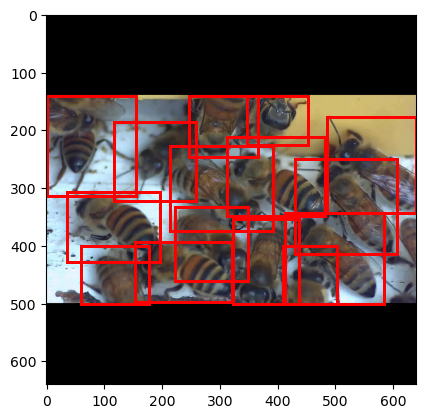

In [135]:
def plot_image_with_boxes(image, targets, anchors, grid_size, batch_index:int=0,image_size=640,):
    """
    이미지와 바운딩 박스를 시각화
    """
    fig, ax = plt.subplots(1)
    ax.imshow(image.permute(1, 2, 0))  # (C, H, W) -> (H, W, C)
    # 각 스케일에서 타겟 박스 그리기
    for scale_idx in range(len(grid_size)):
        target=targets[scale_idx][batch_index]
        stride = image_size // grid_size[scale_idx]

        # 타겟에서 활성화된 박스만 가져오기
        active_boxes = torch.nonzero(target[..., 0])  # Confidence가 1인 경우
        for box in active_boxes:
            anchor_idx, grid_x, grid_y = box[:3]  # 앵커, 그리드 좌표 추출

            cx, cy, w, h = target[anchor_idx, grid_x, grid_y, 1:5]  # 바운딩 박스 정보

            # 실제 이미지 좌표로 변환
            cx = (grid_x + cx.item()) * stride
            cy = (grid_y + cy.item()) * stride
            w = w.item() * stride
            h = h.item() * stride

            print(cx, cy, w, h)
            # 바운딩 박스 그리기
            rect = patches.Rectangle(
                (cx - w / 2, cy - h / 2), w, h,
                linewidth=2, edgecolor="r", facecolor="none"
            )
            ax.add_patch(rect)
        plt.savefig(f"plot_{scale_idx}.png")

# 이미지와 바운딩 박스 시각화
plot_image_with_boxes(image[0], targets, anchors=dataset.anchors, grid_size=dataset.grid_size)



# Training

In [ ]:
model = YOLOv3(in_channels=3,num_classes=NUM_CLASSES).to(DEVICE)
optimizer = optim.AdamW (model.parameters(), lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY)
loss_fn = YoloLoss(NUM_CLASSES)
scaler = GradScaler()
scaled_anchors = (
    torch.tensor(ANCHORS)
    * torch.tensor(STRIDE).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
).to(DEVICE)